# How to Build and Estimate an ARX Model

IN this example we will generate some SISO data to test 2 different Python pakages for system identification. At first we will write our own code for system identification, finally we will test two different libraries to test the validity of the paramters found. 

Let's strat by generating some data from a SISO system, and devide them into train and test

In [4]:
import numpy as np
import pandas as pd 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


np.random.seed(1)

In [5]:
def generate_siso_data(n, test_size=0.2, noise_level=0.1, a1=0.5, a2=-0.3, b1=0.7, b2=-0.2):
    """
    Generates synthetic Single Input Single Output (SISO) data for an ARX model with na=2 and nb=2.
    :param n: Number of data points to generate.
    :param test_size: Proportion of the dataset to include in the test split.
    :param noise_level: Standard deviation of the noise.
    :param a1, a2: Coefficients for the autoregressive part of the model.
    :param b1, b2: Coefficients for the exogenous input part of the model.
    :return: Tuple of (y_train, x_train, y_test, x_test), where y is the target series and x is the exogenous series.
    """
    # Generating exogenous input (x) as a random signal
    u = np.random.randint(0, 2, size=n)

    # Generating the target series (y)
    y = np.zeros(n)
    for t in range(2, n):
        y[t] = a1 * y[t-1] + a2 * y[t-2] +  b1 * u[t-1] + b2 * u[t-2] + np.random.normal(0, noise_level)

    # Splitting the data into training and testing sets
    y_train, y_test, u_train, u_test = train_test_split(y, u, test_size=test_size, shuffle=False)

    return y_train, u_train, y_test, u_test

In [6]:
true_noise_std = 0.05
y_train, u_train, y_test, u_test = generate_siso_data(n=1000, noise_level=true_noise_std)

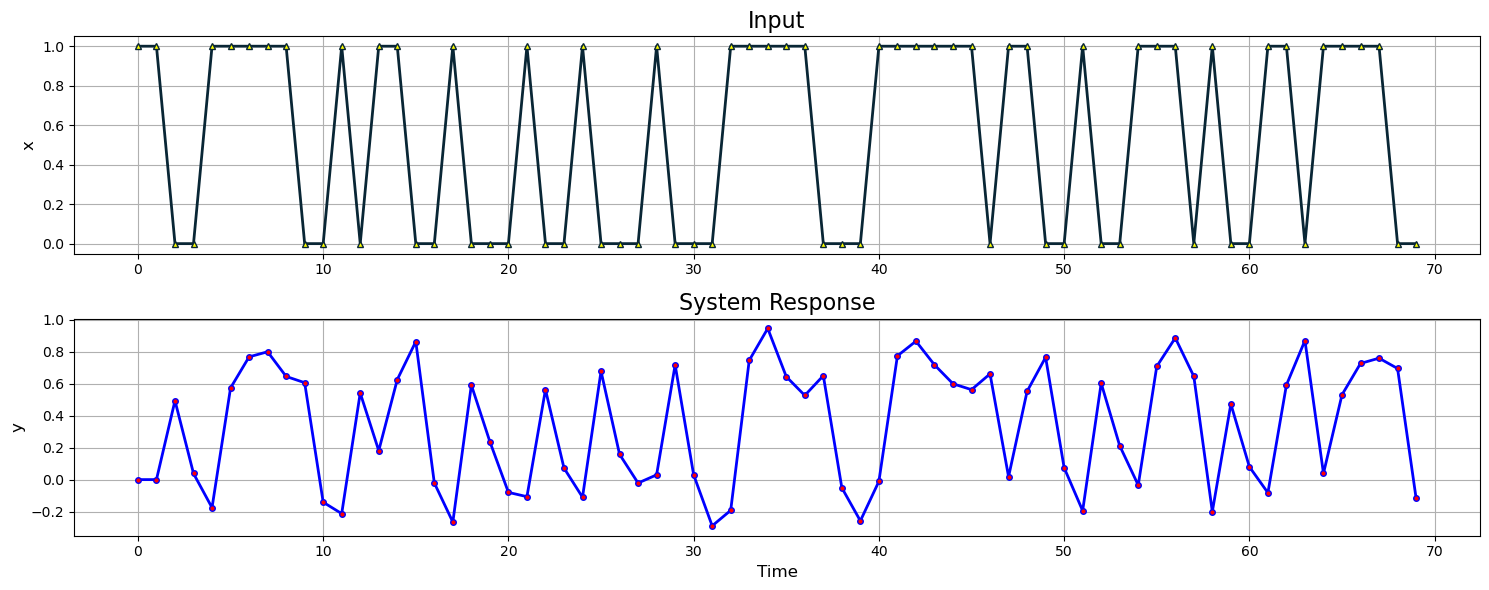

In [7]:
### Data Visualization
STEPS = 70
# Creating a 2-row plot for x and y
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))

axes[0].plot(u_train[:STEPS], color='#092635', linewidth=2, linestyle='-', marker='^', markersize=4, markerfacecolor='yellow')
axes[0].set_title('Input', fontsize=16)
axes[0].set_ylabel('x', fontsize=12)
axes[0].grid(True)
axes[1].plot(y_train[:STEPS], color='blue', linewidth=2, linestyle='-', marker='o', markersize=4, markerfacecolor='red')
axes[1].set_title('System Response', fontsize=16)
axes[1].set_xlabel('Time', fontsize=12)
axes[1].set_ylabel('y', fontsize=12)
axes[1].grid(True)

plt.tight_layout()

# Save the plots as a PDF
#plt.savefig('response.pdf', format='pdf')

plt.show()

### How many Lags to consider? 

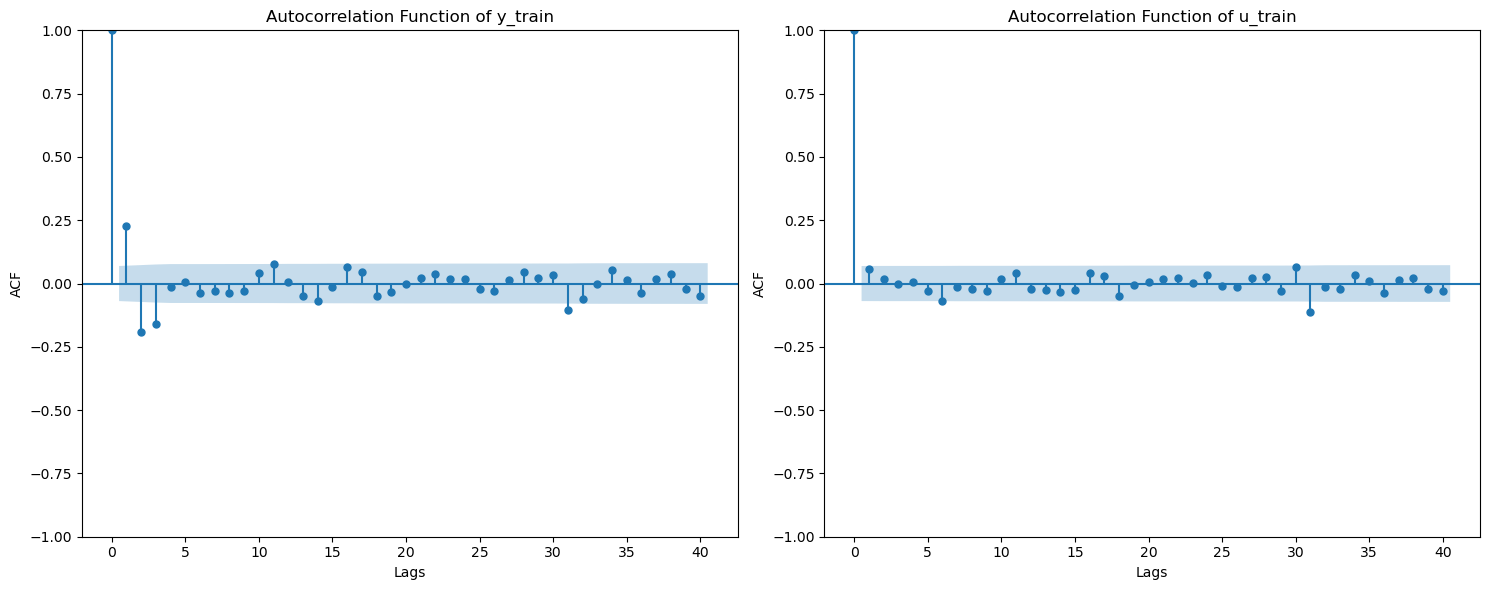

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import ccf

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot the first autocorrelation function
plot_acf(y_train, lags=40, alpha=0.05, ax=axs[0])
axs[0].set_title("Autocorrelation Function of y_train")
axs[0].set_xlabel("Lags")
axs[0].set_ylabel("ACF")

# Plot the second autocorrelation function
plot_acf(u_train, lags=40, alpha=0.05, ax=axs[1])
axs[1].set_title("Autocorrelation Function of u_train")
axs[1].set_xlabel("Lags")
axs[1].set_ylabel("ACF")

# Adjust layout
plt.tight_layout()
#plt.savefig("autocorrelation_plots.pdf", format='pdf')
plt.show()


### Write a function to fit a linear regression on the lags, namely an ARX model

In [9]:
def fit_arx_model(y, u, na, nb):
    """
    :param y: Target time series.
    :param x: Exogenous time series.
    :param na: Order of the autoregressive part.
    :param nb: Order of the exogenous input part.
    :return: Coefficients of A, B and the intercept of the ARX model.
    """
    max_lag = max(na, nb)
    features = []
    target = y[max_lag:]

    for i in range(max_lag, len(y)):
        lag_y = y[i-na:i] if na > 0 else []
        lag_u = u[i-nb:i] if nb > 0 else []
        row = np.concatenate([lag_y, lag_u])
        features.append(row)

    U = np.array(features)
    model = LinearRegression().fit(U, target)
    return model.coef_[:na], model.coef_[na:], model.intercept_

### Print and store the estimated paramters

In [10]:
# Fit ARX model and get A, B coefficients and intercept
na, nb = 2, 2
coefficients_a, coefficients_b, intercept = fit_arx_model(y_train, y_train, na, nb)

our_linear_model_results = pd.DataFrame({
    'Regressors': [f'y(t-{i})' for i in reversed(range(1, na+1))] + [f'u(t-{i})' for i in reversed(range(1, nb+1))] + ['1'],
    'Parameters': list(coefficients_a) + list(coefficients_b) + [intercept],
    'Source': 'Our Model'
}).set_index("Regressors").sort_index()
print(our_linear_model_results)

            Parameters     Source
Regressors                       
1             0.289239  Our Model
u(t-1)        0.143102  Our Model
u(t-2)       -0.129381  Our Model
y(t-1)        0.143102  Our Model
y(t-2)       -0.129381  Our Model


### Framework1 1: SIPPY
#### Suggested if you are more interested in sys id for control and embedded computation. Support much more well-known sys id (linear) models. 

In [11]:
import sys, os
from sippy import *
import numpy as np
from sippy import functionset as fset
from sippy import functionsetSIM as fsetSIM
import matplotlib.pyplot as plt
import pandas as pd
import control as cnt

In [16]:
na_ords = [na]         
nb_ords = [[nb]]       
theta = [[0]] 

id_ARX = system_identification(y_train, u_train, 'ARMAX',  # Note: changed y_train to u_train for input
                             ARX_orders=[na_ords, nb_ords, theta])  

G = id_ARX.G  # Get full transfer function
print("SIPPY is highly specialized for control, so the results are represented as transfer function")
print()
print("Transfer function G(z):")
print(id_ARX.G)

num = id_ARX.NUMERATOR
den = id_ARX.DENOMINATOR

print("However, this is equivalent to: ")
print("y[t] = 0.4865 * y[t-1] - 0.2985 * y[t-2] + 0.6967 * u[t-1] - 0.1896 * u[t-2] + epsilon(t)")

SIPPY is highly specialized for control, so the results are represented as transfer function

Transfer function G(z):

  0.6551
-----------
z - 0.06778

dt = 1.0

However, this is equivalent to: 
y[t] = 0.4865 * y[t-1] - 0.2985 * y[t-2] + 0.6967 * u[t-1] - 0.1896 * u[t-2] + epsilon(t)


In [19]:
print(f"True noise level (std): {true_noise_std:.4f}")
print(f"Estimated noise level (std): {np.sqrt(id_ARX.Vn):.4f}")

True noise level (std): 0.0500
Estimated noise level (std): 0.2219


In [11]:
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.parameter_estimation import LeastSquares


### Framework2: SysIdentipy
#### Suggested if you are more interested in more in learning than control and you want an easier life. You can use different estimators, from linear model to non-linear and machine learning.


In [12]:
basis_function = Polynomial(degree=1)
estimator = LeastSquares()


model = FROLS(
    order_selection=False,
    n_terms=5,
    ylag=2,
    xlag=2,
    basis_function=basis_function,
    estimator=estimator,
)

model.fit(X=u_train.reshape(-1,1), y=y_train.reshape(-1,1))

In [13]:
from sysidentpy.utils.display_results import results

sysidentpy_model_results = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=4,
        dtype="dec",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)[["Regressors", "Parameters"]].set_index("Regressors").sort_index()
print(sysidentpy_model_results)

           Parameters
Regressors           
1              0.0030
x1(k-1)        0.6954
x1(k-2)       -0.1946
y(k-1)         0.4918
y(k-2)        -0.3010


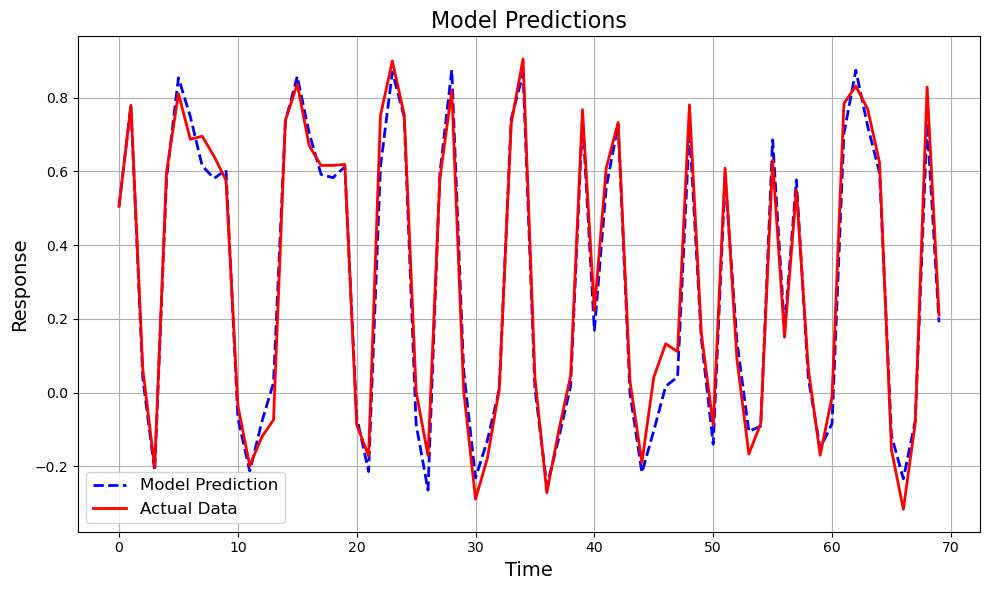

In [14]:
yhat = model.predict(X=u_test.reshape(-1,1), y=y_test.reshape(-1,1)).squeeze()

plt.figure(figsize=(10, 6))
plt.plot(yhat[:STEPS], label='Model Prediction', color='blue', linewidth=2, linestyle='--')
plt.plot(y_test[:STEPS], label='Actual Data', color='red', linewidth=2)

# Enhancing the plot with additional features
plt.title('Model Predictions', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Response', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

#plt.savefig('response_yhat.pdf', format='pdf')
plt.show()

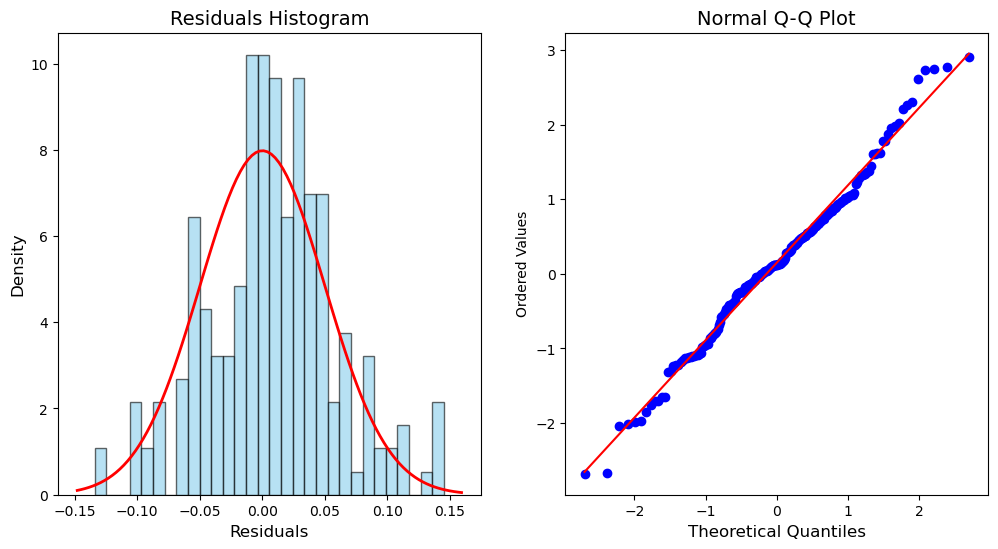

Shapiro-Wilk test result: statistic=0.9897, p-value=0.1603
The residuals are compatible with a Gaussian distribution.


In [15]:
from matplotlib.backends.backend_pdf import PdfPages
import scipy.stats as stats

residuals = y_test - yhat

# Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(residuals)

# Compare with a Gaussian distribution
mu = 0
sigma = 0.05
z_scores = (residuals - mu) / sigma

# Creating a PDF file to save plots
#pdf = PdfPages("../img/residuals_analysis.pdf")

# Plotting in a more aesthetic manner
plt.figure(figsize=(12, 6))

# Histogram of the residuals
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)
plt.title("Residuals Histogram", fontsize=14)
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Density", fontsize=12)

# QQ plot
plt.subplot(1, 2, 2)
stats.probplot(z_scores, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot", fontsize=14)
plt.xlabel("Theoretical Quantiles", fontsize=12)


plt.show()

# Output the results of the Shapiro-Wilk test
shapiro_result = f"Shapiro-Wilk test result: statistic={shapiro_test[0]:.4f}, p-value={shapiro_test[1]:.4f}"
compatibility_result = "The residuals are compatible with a Gaussian distribution." if shapiro_test[1] > 0.05 else "The residuals are not compatible with a Gaussian distribution."
print(f"Shapiro-Wilk test result: statistic={shapiro_test[0]:.4f}, p-value={shapiro_test[1]:.4f}")
print("The residuals are compatible with a Gaussian distribution." if shapiro_test[1] > 0.05 else "The residuals are not compatible with a Gaussian distribution.")

### Framework 3: Gekko
#### Suggested if you are interested in paramters estimation and control all-in one framework. 

In [15]:
from gekko import GEKKO

m = GEKKO()

# system identification
t = np.arange(0, len(u_train))
na = 2 # output coefficients
nb = 2 # input coefficients
yp,p,K = m.sysid(t, u_train, y_train, na, nb, pred='meas')

gekko_model_results = pd.DataFrame({
    'Regressors': [f'y(t-{i})' for i in range(1, na+1)] + [f'x(t-{i})' for i in range(1, nb+1)] + ['1'],
    'Parameters': list(p["a"].squeeze()) + list(p["b"].squeeze()) + [p["c"][0]],
    'Source': 'Gekko'
}).set_index("Regressors").sort_index()
print(gekko_model_results)

            Parameters Source
Regressors                   
1             0.002977  Gekko
x(t-1)        0.695373  Gekko
x(t-2)       -0.194563  Gekko
y(t-1)        0.491774  Gekko
y(t-2)       -0.300984  Gekko
